# Semi supervised learning models

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle

In [5]:
import pomegranate as pg
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.metrics import roc_auc_score
from sklearn.datasets import load_breast_cancer

In [6]:
import warnings
warnings.simplefilter('ignore') #we don't wanna see that
np.random.seed(1) #i'm locking seed at the begining since we will use some heavy RNG stuff, be aware


Atributes:

    ID number
    Diagnosis (M = malignant, B = benign)

Ten real-valued features are computed for each cell nucleus:

    radius (mean of distances from center to points on the perimeter)
    texture (standard deviation of gray-scale values)
    perimeter
    area
    smoothness (local variation in radius lengths)
    compactness (perimeter^2 / area - 1.0)
    concavity (severity of concave portions of the contour)
    concave points (number of concave portions of the contour)
    symmetry
    fractal dimension ("coastline approximation" - 1)


In [15]:
data         = load_breast_cancer() # here, the data is an array
df           = pd.DataFrame(data.data, columns = data.feature_names)
df['target'] = data['target']


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
mean radius                569 non-null float64
mean texture               569 non-null float64
mean perimeter             569 non-null float64
mean area                  569 non-null float64
mean smoothness            569 non-null float64
mean compactness           569 non-null float64
mean concavity             569 non-null float64
mean concave points        569 non-null float64
mean symmetry              569 non-null float64
mean fractal dimension     569 non-null float64
radius error               569 non-null float64
texture error              569 non-null float64
perimeter error            569 non-null float64
area error                 569 non-null float64
smoothness error           569 non-null float64
compactness error          569 non-null float64
concavity error            569 non-null float64
concave points error       569 non-null float64
symmetry error             569 

we will shuffle our dataset since it has order and we don't want that. Also, we'll reduce dimensionality by dipping features to simplify everything.

We'll create ethe X and Y and split them intro 3 parts:
1) labeled data
2) unlabeled data
3) drop features (worst columns; area/perimeter is redundant since it's highly correlated to the radius; concave points feature is redundant too and correlates to concavity and compactness).

In [24]:
df = shuffle(df, random_state = 1)
X  = df.drop(['target', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 
             'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 
             'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 
             'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 
             'worst fractal dimension', 'mean area', 'mean perimeter', 'mean concave points'], axis=1)
# X values would be the mean values. 
y = df['target']


will plot pointplots between each features and their distribution on diagonal.

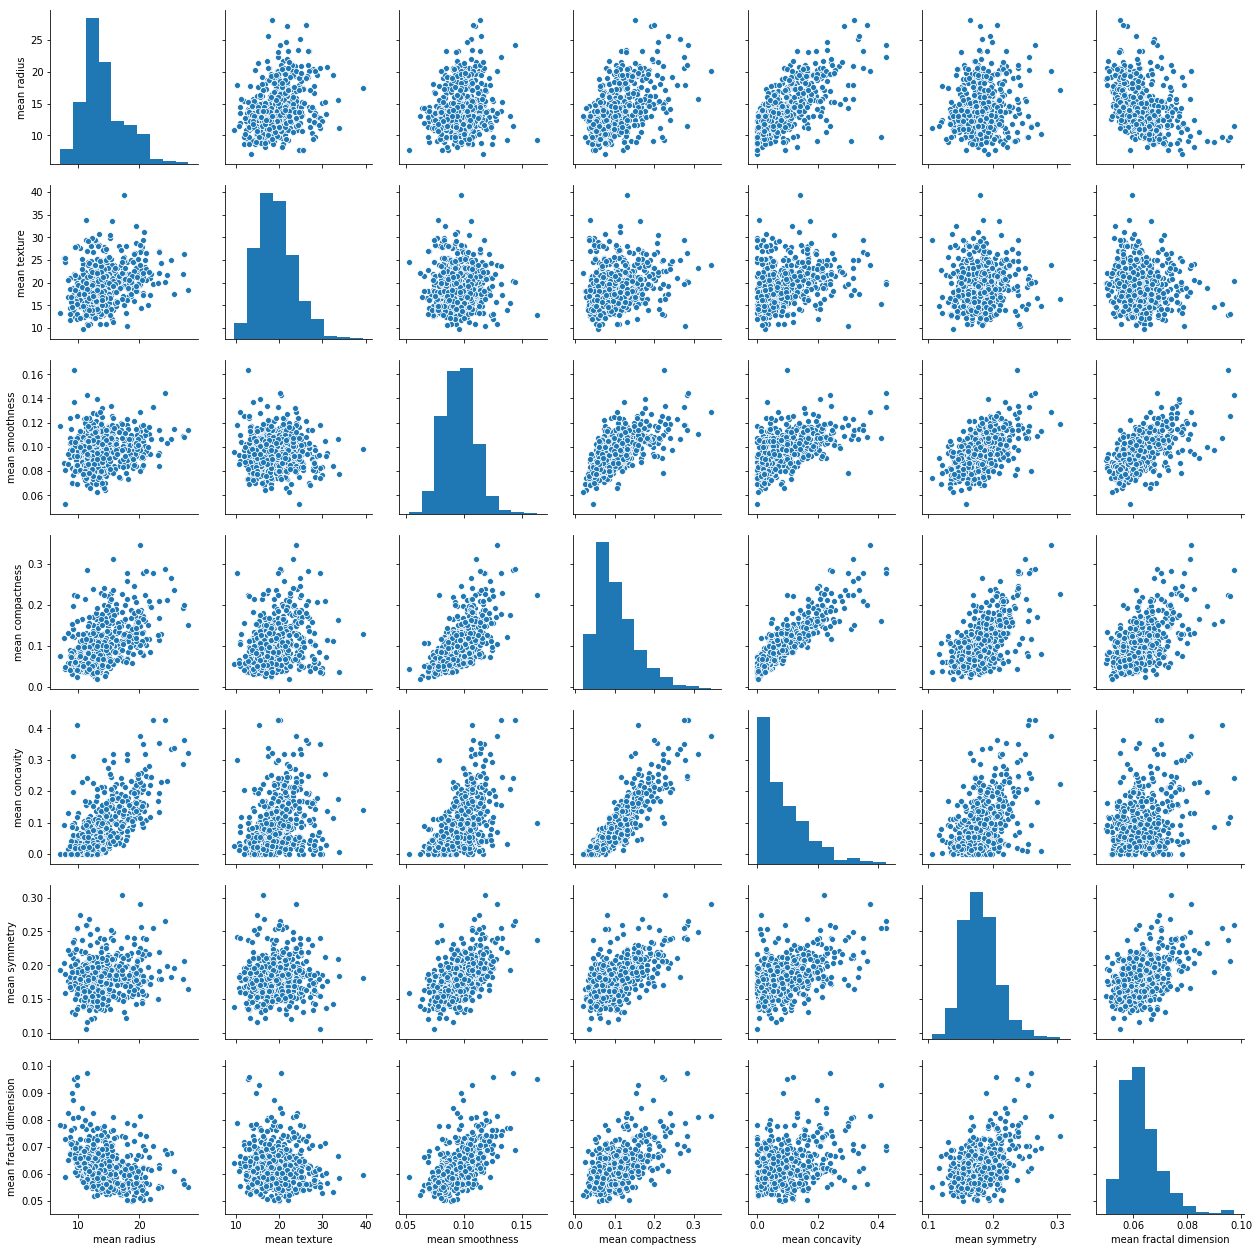

In [25]:
sns.pairplot(X)

Now we will merge labeled and unlabeled data. Labeling unlabeled data -1.

In [26]:
X_1, X_2, X_3  = np.split(X, [int(.1*len(X)), int(.5*len(X))])
y_1, y_2, y_3  = np.split(y, [int(.1*len(y)), int(.5*len(y))])
y_1_2 = np.concatenate((y_1, y_2.apply(lambda x: -1)))
X_1_2 = np.concatenate((X_1, X_2))

In [28]:
index = ['Algorithm', 'ROC AUC']
results = pd.DataFrame(columns=index)

In [29]:
logreg = LogisticRegression(random_state=1, class_weight='balanced')
logreg.fit(X_1, y_1)
results = results.append(pd.Series(['Logistic Regression', roc_auc_score(y_3, logreg.predict_proba(X_3)[:,1])], 
                                   index=index), ignore_index=True)
results

,Algorithm,ROC AUC
0,Logistic Regression,0.858632


In [30]:
%%timeit
logreg_test = LogisticRegression(random_state=1, class_weight='balanced')
logreg_test.fit(df, y)
logreg_test.predict_proba(df);

15.7 ms ± 2.22 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
